In [1]:
import copy
import random

import numpy as np
import torch
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from Grin import get_dataset
from torch import Tensor, nn
from torch.nn import MultiheadAttention
from torch_geometric.utils import dense_to_sparse
from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.nn import utils
from tsl.nn.blocks.decoders import MLPDecoder
from tsl.nn.blocks.encoders import RNN
from tsl.nn.blocks.encoders.mlp import MLP
from tsl.nn.layers.graph_convs import GraphConv
from tsl.nn.models.base_model import BaseModel
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

In [16]:
class UnnamedKrigModel(BaseModel):
    return_type = tuple

    def __init__(self,
                 input_size,
                 hidden_size,
                 output_size,
                 adj,
                 horizon,
                 exog_size,
                 enc_layers,
                 gcn_layers,
                 norm='mean',
                 encode_edges=False,
                 activation='softplus',
                 n_heads=8,
                 device='cpu'):
        super(UnnamedKrigModel, self).__init__()

        input_size += exog_size
        self.input_encoder_fwd = RNN(input_size=input_size,
                                 hidden_size=hidden_size,
                                 n_layers=enc_layers,
                                 return_only_last_state=False,
                                 cell='gru')
        
        self.input_encoder_bwd = RNN(input_size=input_size,
                                 hidden_size=hidden_size,
                                 n_layers=enc_layers,
                                 return_only_last_state=False,
                                 cell='gru')

        if encode_edges:
            self.edge_encoder = nn.Sequential(
                RNN(input_size=input_size,
                    hidden_size=hidden_size,
                    n_layers=enc_layers,
                    return_only_last_state=True,
                    cell='gru'),
                nn.Linear(hidden_size, 1),
                nn.Softplus(),
                Rearrange('e f -> (e f)', f=1),
            ).to(device)
        else:
            self.register_parameter('edge_encoder', None)

        self.gcn_layers_fwd = nn.ModuleList([
            GraphConv(hidden_size,
                      hidden_size,
                      root_weight=False,
                      norm=norm,
                      activation=activation) for _ in range(gcn_layers)
        ])

        self.gcn_layers_bwd = nn.ModuleList([
            GraphConv(hidden_size,
                      hidden_size,
                      root_weight=False,
                      norm=norm,
                      activation=activation) for _ in range(gcn_layers)
        ])

        self.skip_con_fwd = nn.Linear(hidden_size, hidden_size)

        self.skip_con_bwd = nn.Linear(hidden_size, hidden_size)

        self.key = MLP(input_size=hidden_size*2,
                        hidden_size=hidden_size,
                        output_size=hidden_size,
                        activation=activation)
        self.query = MLP(input_size=hidden_size*2,
                        hidden_size=hidden_size,
                        output_size=hidden_size,
                        activation=activation)
        self.value = MLP(input_size=hidden_size*2,
                        hidden_size=hidden_size,
                        output_size=hidden_size,
                        activation=activation)
        
        self.multihead = MultiheadAttention(hidden_size, n_heads, batch_first=True)
        self.adj = adj
        self.adj_n1 = None
        self.adj_n2 = None
        self.obs_neighbors = None

    def forward(self,
                x,
                mask=None,
                known_set=None,
                sub_entry_num=None,
                edge_weight=None,
                edge_features=None,
                training=False,
                reset=False,
                u=None):
        # x: [batches steps nodes features]
        # Unrandomised x, make sure this only has training nodes
        # x transferred here would be the imputed x
        # adj is the original 
        # mask is for nodes that need to get predicted, mask is also imputed 

        x = utils.maybe_cat_exog(x, u)
        device = x.device
        o_adj = self.adj.clone().to(device)

        if training:
            o_adj = o_adj[known_set, :]
            o_adj = o_adj[:, known_set]

        edge_index, edge_weight = dense_to_sparse(o_adj)
        # ========================================
        # Simple GRU-GCN embedding
        # ========================================
        # Bigger encoders might exacerbate confounders 

        # flat time dimension fwd and bwd
        x_fwd = self.input_encoder_fwd(x)
        x_bwd = self.input_encoder_bwd(torch.flip(x, (1,)))

        # Edge encoder
        if self.edge_encoder is not None:
            assert edge_weight is None
            edge_weight = self.edge_encoder(edge_features)

        # forward encoding 
        out_f = x_fwd
        for layer in self.gcn_layers_fwd:
            out_f = layer(out_f, edge_index, edge_weight)
        out_f = out_f + self.skip_con_fwd(x_fwd)

        # backward encoding
        out_b = x_bwd
        for layer in self.gcn_layers_bwd:
            out_b = layer(out_b, edge_index, edge_weight)
        out_b = out_b + self.skip_con_bwd(x_bwd)

        # Concatenate backward and forward processes
        sum_out = torch.cat([out_f, out_b], dim=3)

        # ========================================
        # Calculating variant and invariant features using self-attention across different nodes using their representations
        # ========================================

        # Query represents new matrix
        query = self.query(sum_out)
        key = self.key(sum_out)
        value = self.value(sum_out)

        adj_var = []
        adj_invar = []
        output_invars = []
        output_vars = []

        # Calculate cross attention between Q and K,V
        # Do this for the two Queries 
        for t in range(x.shape[1]):
            q = query[:, t]
            k = key[:, t]
            v = value[:, t]

            att_var, att_invar, output_invar, output_var = self.scaled_dot_product_attention(q, k, v, mask = o_adj)
            
            adj_var.append(att_var)
            adj_invar.append(att_invar)
            output_invars.append(output_invar)
            output_vars.append(output_var)
        
        # [batch, time, nodes, nodes]
        adj_var = torch.stack(adj_var).permute(1, 0, 2, 3).to(device)
        adj_invar = torch.stack(adj_invar).permute(1, 0, 2, 3).to(device)
        output_invars = torch.stack(output_invars).permute(1, 0, 2, 3).to(device)
        output_vars = torch.stack(output_vars).permute(1, 0, 2, 3).to(device)
            
        # TODO: Check distributions after training

        # ========================================
        # Create new adjacency matrix 
        # ========================================
        # Get two graphs, one with one hop connections, another with two hop connections

        # TODO: need to put this in the filler
        if training:
            if reset:
                b, s, n, d = mask.size()

                sub_entry = torch.zeros(b, s, sub_entry_num, d).to(device)
                x = torch.cat([x, sub_entry], dim=2)  # b s n2 d
                mask = torch.cat([mask, sub_entry], dim=2).byte()  # b s n2 d
                # y = torch.cat([y, sub_entry], dim=2)  # b s n2 d

                adj_n1, adj_n2 = self.get_new_adj(o_adj, sub_entry_num)
            else:
                if self.adj_n1 is None and self.adj_n2 is None:
                    adj_n1 = o_adj
                    adj_n2 = o_adj
                else:
                    assert self.adj_n2 is not None and self.adj_n1 is not None
                    adj_n1 = self.adj_n1
                    adj_n2 = self.adj_n2

        # Edge weights must be scaled down 
        # Need to propagate this too
        # Need to scale the new edges based on the probability of the softmax
        # TODO: optimise this
        b, t, n, _ = adj_invar.shape
        adj_invar_exp_n1 = torch.stack([adj_n1]*t).to(device)
        adj_invar_exp_n1 = torch.stack([adj_invar_exp_n1]*b)
        adj_invar_exp_n1[:, :, :n, :n] = adj_invar

        adj_invar_exp_n2 = torch.stack([adj_n2]*t).to(device)
        adj_invar_exp_n2 = torch.stack([adj_invar_exp_n2]*b)
        adj_invar_exp_n2[:, :, :n, :n] = adj_invar

        adj_var_exp_n1 = torch.stack([adj_n1]*t).to(device)
        adj_var_exp_n1 = torch.stack([adj_var_exp_n1]*b)
        adj_var_exp_n1[:, :, :n, :n] = adj_var

        adj_var_exp_n2 = torch.stack([adj_n2]*t).to(device)
        adj_var_exp_n2 = torch.stack([adj_var_exp_n2]*b)
        adj_var_exp_n2[:, :, :n, :n] = adj_var

        # Propagate variant and invariant features to new nodes features

        
        # ========================================
        # Kriging model
        # ========================================
        # Predict the real nodes by propagating back using just the invariant features
        # Get reconstruction loss

        # Predict the real nodes by propagating back using both variant and invariant features
        # Get IRM loss

        # ========================================
        # Size regularisation
        # ========================================
        # Regularise both graphs using CMD using 
        # <https://proceedings.neurips.cc/paper_files/paper/2022/file/ceeb3fa5be458f08fbb12a5bb783aac8-Paper-Conference.pdf>

        
        # ========================================
        # Final prediction
        # ========================================
        # With the final representations, predict the unknown nodes again, just using the invariant features
        # Get reconstruction loss with pseudo labels 

        return out_f, out_b, (out_f+out_b), adj_invar_exp_n1, adj_invar_exp_n2, adj_var_exp_n1, adj_var_exp_n2, output_invars

    def get_new_adj(self, adj, sub_entry_num):
        n1 = adj.shape[0]
        
        if self.obs_neighbors is None:
            neighbors_1h = {}
            neighbors_2h = {}

            # Get two hop diagonal
            sp_adj = adj.to_sparse_coo()
            two_hops = torch.mm(sp_adj, sp_adj).to_dense()
            two_hops = two_hops.fill_diagonal_(0)

            for i in range(n1):
                row_n_1 = set(torch.nonzero(adj[i]).squeeze(1).tolist())
                col_n_1 = set(torch.nonzero(adj[:, i]).squeeze(1).tolist())
                all_n_1 = row_n_1.union(col_n_1)

                # 1-hop neighbors
                neighbors_1h[i] = list(all_n_1)

                row_n_2 = set(torch.nonzero(two_hops[i]).squeeze(1).tolist())
                col_n_2 = set(torch.nonzero(two_hops[:, i]).squeeze(1).tolist())
                all_n_2 = row_n_2.union(col_n_2)
                all_n = all_n_2.union(all_n_1)

                # 1 and 2 hop neighbors
                neighbors_2h[i] = list(all_n)
                
            self.obs_neighbors = (neighbors_1h, neighbors_2h)
        else:
            neighbors_1h, neighbors_2h = self.obs_neighbors  # n1, n1, note that cannot use copy!!!

        n2 = n1 + sub_entry_num
        # Create matrices for both n1 and n2
        adj_aug_n1 = torch.ones((n2, n2)).to(device = adj.device)  # n2, n2
        adj_aug_n2 = torch.ones((n2, n2)).to(device = adj.device)  # n2, n2

        # preserve original observed parts in newly-created adj
        adj_aug_n1[:n1, :n1] = adj
        adj_aug_n2[:n1, :n1] = adj

        adj_aug_n1 = adj_aug_n1.fill_diagonal_(0)
        adj_aug_n2 = adj_aug_n2.fill_diagonal_(0)

        adj_aug_mask_n1 = torch.zeros_like(adj_aug_n1)  # n2, n2
        adj_aug_mask_n2 = torch.zeros_like(adj_aug_n2)  # n2, n2

        adj_aug_mask_n1[:n1, :n1] = 1
        adj_aug_mask_n2[:n1, :n1] = 1

        neighbors_1 = copy.deepcopy(neighbors_1h)
        neighbors_2 = copy.deepcopy(neighbors_2h)

        for i in range(n1, n2):
            n_current = range(len(neighbors_1.keys()))  # number of current entries (obs and already added virtual)
            rand_entry = random.sample(n_current, 1)[0] # randomly sample 1 entry (obs or already added virtual)
            rand_neighbors_1 = neighbors_1[rand_entry]  # get 1-hop neighbors of sampled entry
            rand_neighbors_2 = neighbors_2[rand_entry]  # get 1 and 2-hop neighbors of sample entry

            p = np.random.rand(1)

            # randomly select 1 hop neighbors
            valid_neighbors_1 = (np.random.rand(len(rand_neighbors_1)) < p).astype(int)
            valid_neighbors_1 = np.where(valid_neighbors_1 == 1)[0].tolist()
            valid_neighbors_1 = [rand_neighbors_1[idx] for idx in valid_neighbors_1]

            all_entries = [rand_entry]
            all_entries.extend(valid_neighbors_1)

            # add current virtual entry to the 1-hop neighbors of selected entries
            for entry in all_entries:
                neighbors_1[entry].append(i)

            # add selected entries to the 1-hop neighbors of current virtual entry
            neighbors_1[i] = all_entries

            # Add to mask
            for j in range(len(all_entries)):
                entry = all_entries[j]
                adj_aug_mask_n1[entry, i] = 1
                adj_aug_mask_n1[i, entry] = 1

            # randomly select 1-2 hop neighbors
            valid_neighbors_2 = (np.random.rand(len(rand_neighbors_2)) < p).astype(int)
            valid_neighbors_2 = np.where(valid_neighbors_2 == 1)[0].tolist()
            valid_neighbors_2 = [rand_neighbors_2[idx] for idx in valid_neighbors_2]

            all_entries = [rand_entry]
            all_entries.extend(valid_neighbors_2)

            # add current virtual entry to the 1-2 hop neighbors of selected entries
            for entry in all_entries:
                neighbors_2[entry].append(i)

            # add selected entries to the 1-2 hop neighbors of current virtual entry
            neighbors_2[i] = all_entries

            # Add to mask
            for j in range(len(all_entries)):
                entry = all_entries[j]
                adj_aug_mask_n2[entry, i] = 1
                adj_aug_mask_n2[i, entry] = 1

        adj_aug_n1 *= adj_aug_mask_n1
        adj_aug_n2 *= adj_aug_mask_n2
    
        return adj_aug_n1, adj_aug_n2
            

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
    # Compute the dot products between Q and K, then scale by the square root of the key dimension
        d_k = Q.size(-1)
        scores_var = -torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        scores_invar = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # Apply mask if provided (useful for masked self-attention in transformers)
        if mask is not None:
            scores_var = scores_var.masked_fill(mask == 0, float('-inf'))
            scores_invar = scores_invar.masked_fill(mask == 0, float('-inf'))

        # Softmax to normalize scores, producing attention weights
        attention_weights_var = F.softmax(scores_var, dim=-1)
        attention_weights_invar = F.softmax(scores_invar, dim=-1)

        # Value should be aggregated using the attention weights as adjacency matrix weights
        output_invar = torch.matmul(attention_weights_invar, V)
        output_var = torch.matmul(attention_weights_var, V)

        return attention_weights_var, attention_weights_invar, output_invar, output_var

In [17]:
mask_s = list(range(0, 69))
known_set = list(range(69, 207))
dataset = get_dataset('metrla', p_noise=0.5, masked_s=mask_s)
# covariates = {'u': dataset.datetime_encoded('day').values}
adj = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False, layout='dense', force_symmetric=True)
adj_list = dataset.get_connectivity(method='distance', threshold=0.1, include_self=False, force_symmetric=True)

adj_weights = torch.tensor(adj_list[1])
adj_list_t = torch.tensor(adj_list[0])
adj = torch.tensor(adj)

torch_dataset = ImputationDataset(target=dataset.dataframe(),
                                    mask=dataset.training_mask,
                                    eval_mask=dataset.eval_mask,
                                #   covariates=covariates,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=12,
                                    stride=1)

scalers = {'target': StandardScaler(axis=(0, 1))}

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(val_len= 0.1, test_len= 0.2),
    batch_size=128,
    workers=0)
dm.setup(stage='fit')

batch = next(iter(dm.train_dataloader()))

input_size = 1
hidden_size = 128
output_size = 1
horizon = 12
exog_size = 0
enc_layers = 2
gcn_layers = 1

model = UnnamedKrigModel(input_size=input_size,
                    hidden_size=hidden_size,
                    output_size=output_size,
                    horizon=horizon,
                    exog_size=exog_size,
                    enc_layers=enc_layers,
                    gcn_layers=gcn_layers,
                    adj=adj)

x = batch['x'][:, :, known_set, :]
mask = batch['mask'][:, :, known_set, :]
sub_entry_num = 65


In [10]:
def test(adj):
    n1 = adj.size(0)
    neighbors_1h = {}
    neighbors_2h = {}

    # Get two hop diagonal
    sp_adj = adj.to_sparse_coo()
    two_hops = torch.mm(sp_adj, sp_adj).to_dense()
    two_hops = two_hops.fill_diagonal_(0)

    for i in range(n1):
        row_n_1 = set(torch.nonzero(adj[i]).squeeze(1).tolist())
        col_n_1 = set(torch.nonzero(adj[:, i]).squeeze(1).tolist())
        all_n_1 = row_n_1.union(col_n_1)

        neighbors_1h[i] = list(all_n_1)

        row_n_2 = set(torch.nonzero(two_hops[i]).squeeze(1).tolist())
        col_n_2 = set(torch.nonzero(two_hops[:, i]).squeeze(1).tolist())
        all_n_2 = row_n_2.union(col_n_2)
        all_n = all_n_2.union(all_n_1)

        neighbors_2h[i] = list(all_n)

    return neighbors_1h, neighbors_2h

test(adj_matrix)

NameError: name 'adj_matrix' is not defined

In [18]:
adj_weights = torch.tensor(adj_list[1])
adj_weights

tensor([0.2609, 0.5190, 0.5088,  ..., 0.6210, 0.2779, 0.6495])

In [19]:
out_f, out_b, _, adj_invar_exp_n1, adj_invar_exp_n2, adj_var_exp_n1, \
    adj_var_exp_n2, output_invars = model(x=x, edge_weight=None, sub_entry_num=sub_entry_num,
                                            mask=mask, known_set=known_set, training=True, reset=True)

In [20]:
adj_var_exp_n1.shape

torch.Size([128, 12, 203, 203])

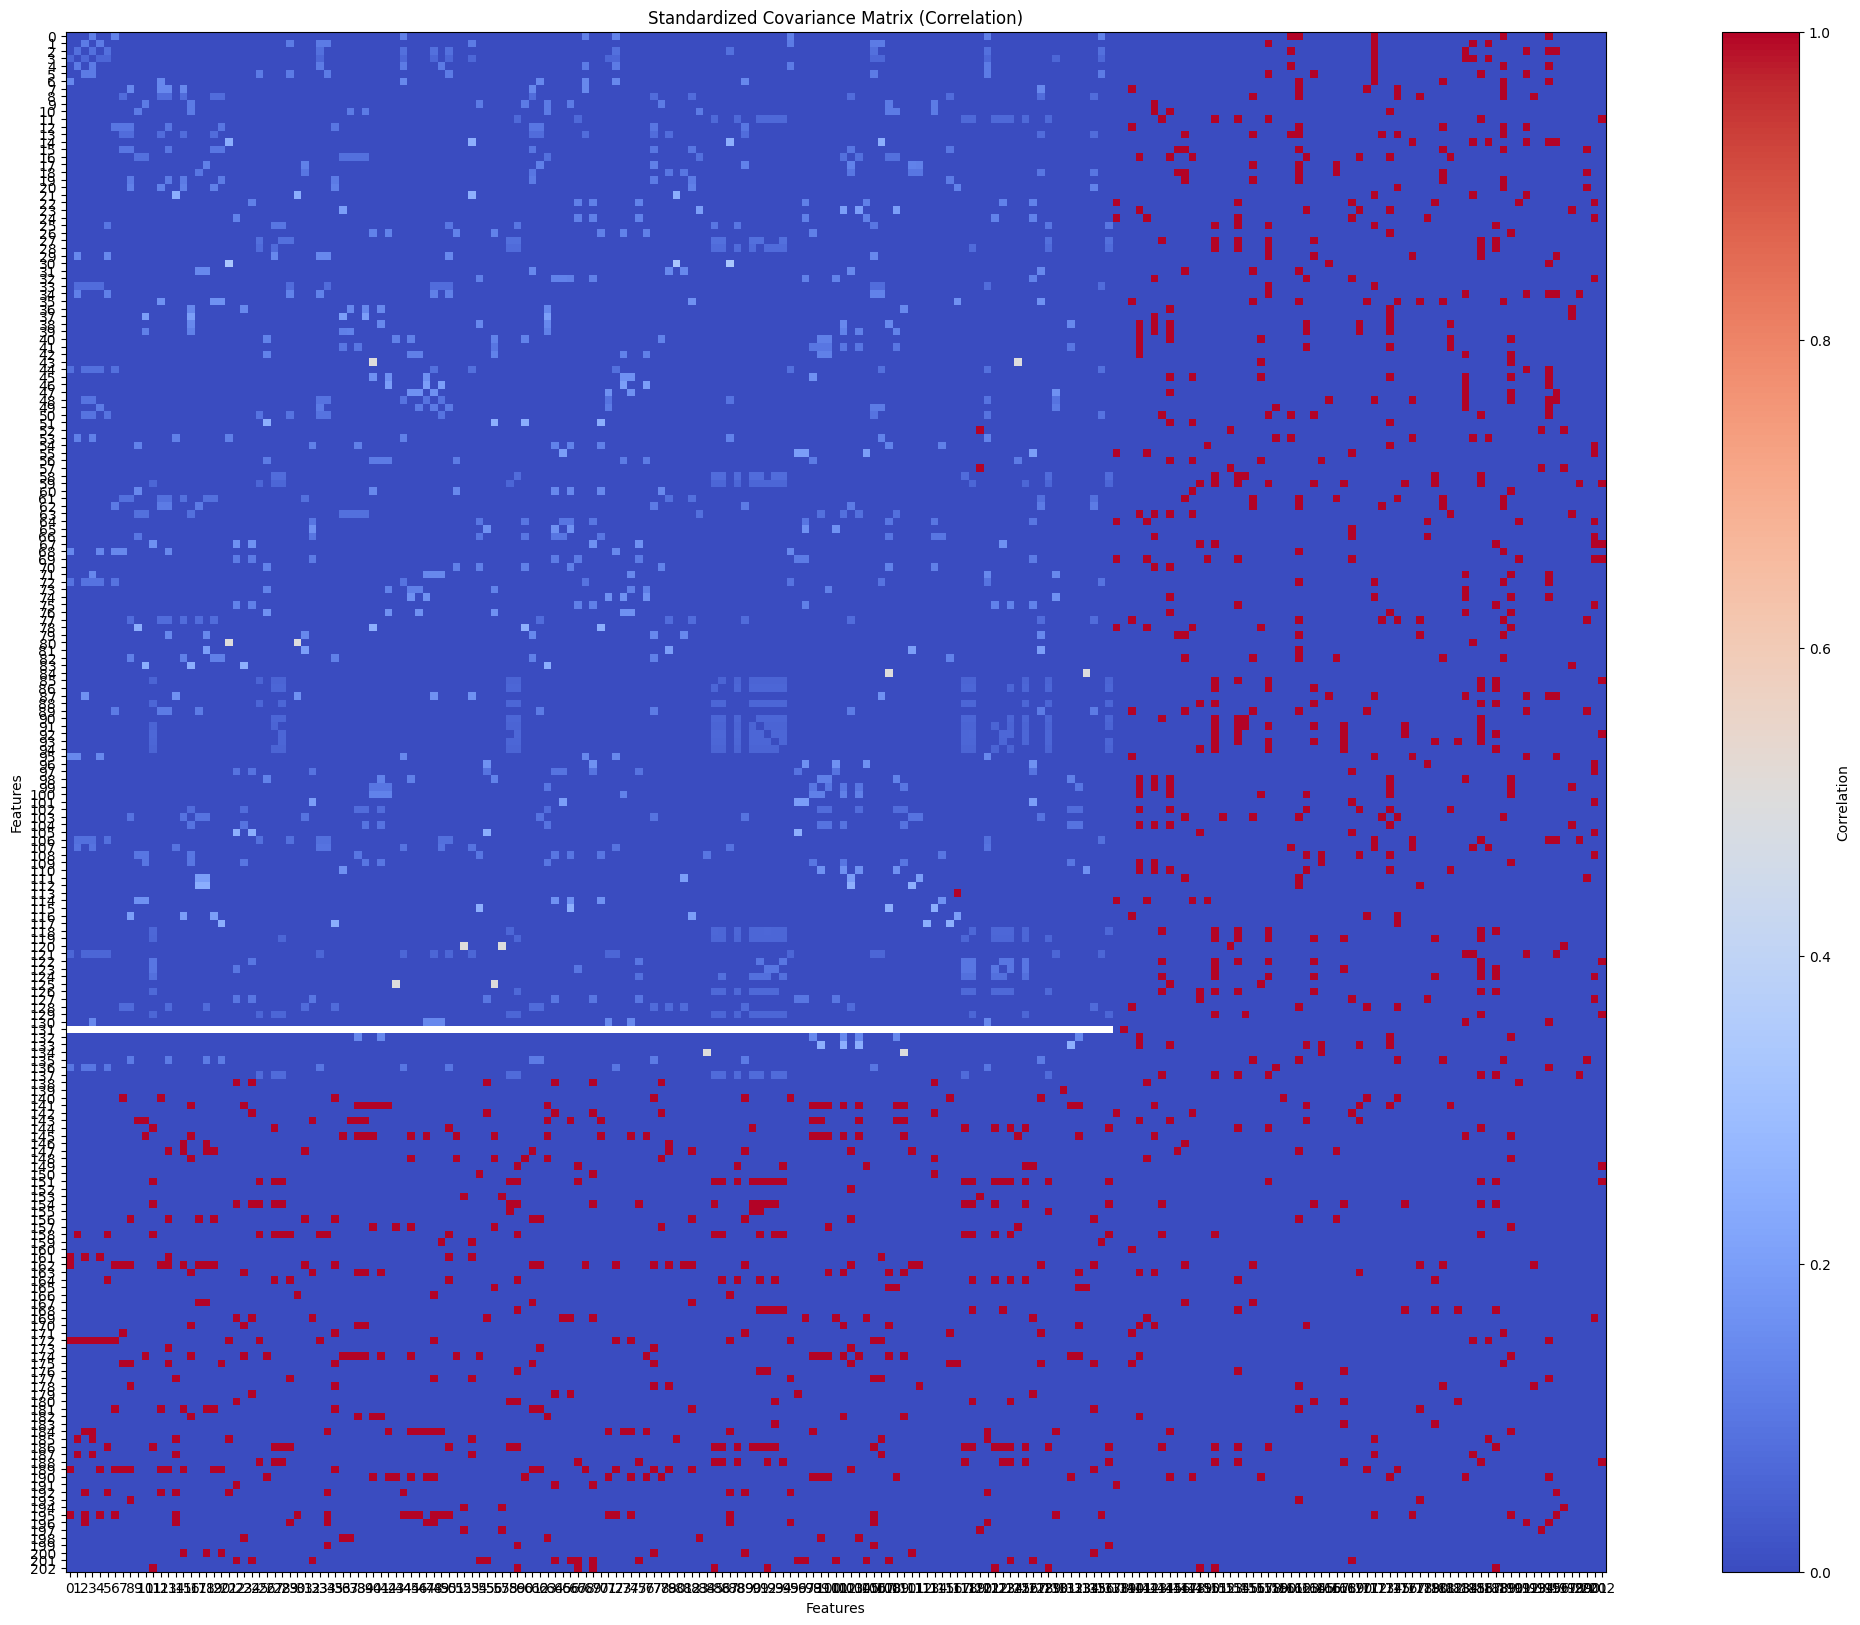

In [21]:
import matplotlib.pyplot as plt

aj_mat = adj_var_exp_n2[0][1].detach().numpy()

plt.figure(figsize=(30, 20))
plt.imshow(aj_mat, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(aj_mat.shape[0]))
plt.yticks(range(aj_mat.shape[1]))
plt.show()

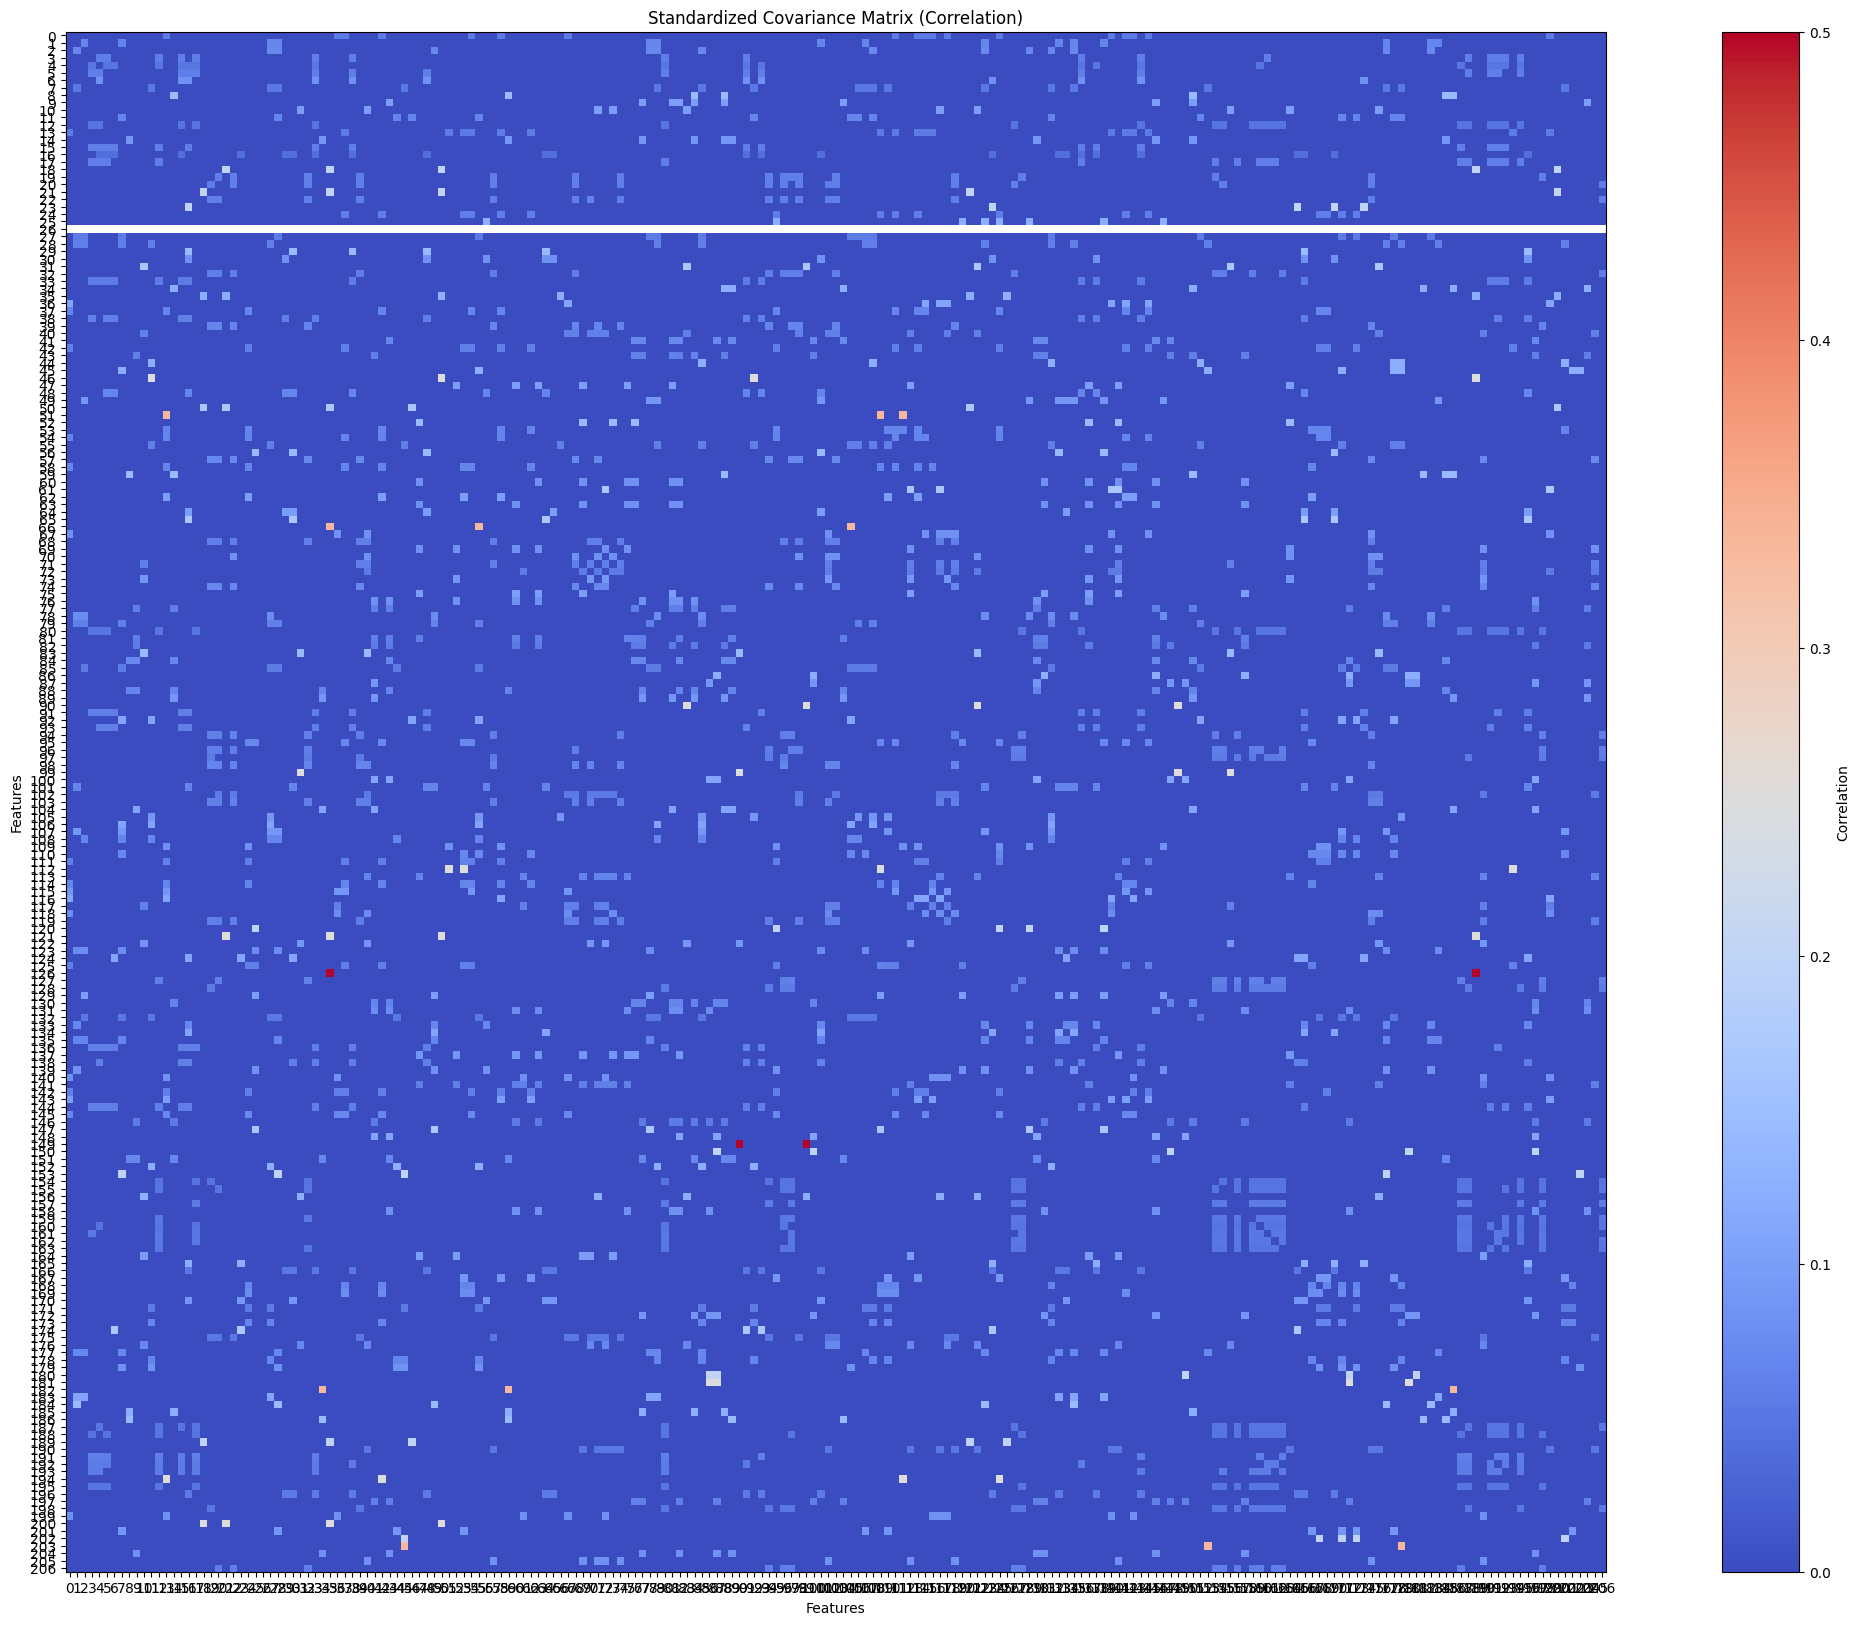

In [21]:
import matplotlib.pyplot as plt

aj_mat = adj_invar[1].detach().numpy()[10]

plt.figure(figsize=(30, 20))
plt.imshow(aj_mat, cmap="coolwarm", interpolation="nearest")
plt.colorbar(label="Correlation")

# # Add text annotations
# for i in range(standardized_cov_matrix.shape[0]):
#     for j in range(standardized_cov_matrix.shape[1]):
#         plt.text(j, i, f"{standardized_cov_matrix[i, j]:.2f}", ha="center", va="center", color="black")

plt.title("Standardized Covariance Matrix (Correlation)")
plt.xlabel("Features")
plt.ylabel("Features")
plt.xticks(range(aj_mat.shape[0]))
plt.yticks(range(aj_mat.shape[1]))
plt.show()

In [102]:
mat[0]

tensor([[[0.0046, 0.0046, 0.0046,  ..., 0.0046, 0.0046, 0.0046],
         [0.0046, 0.0046, 0.0095,  ..., 0.0046, 0.0046, 0.0046],
         [0.0046, 0.0095, 0.0046,  ..., 0.0046, 0.0046, 0.0046],
         ...,
         [0.0047, 0.0047, 0.0047,  ..., 0.0047, 0.0047, 0.0047],
         [0.0047, 0.0047, 0.0047,  ..., 0.0047, 0.0047, 0.0047],
         [0.0046, 0.0046, 0.0046,  ..., 0.0046, 0.0046, 0.0046]],

        [[0.0046, 0.0046, 0.0046,  ..., 0.0046, 0.0046, 0.0046],
         [0.0046, 0.0046, 0.0095,  ..., 0.0046, 0.0046, 0.0046],
         [0.0046, 0.0095, 0.0046,  ..., 0.0046, 0.0046, 0.0046],
         ...,
         [0.0047, 0.0047, 0.0047,  ..., 0.0047, 0.0047, 0.0047],
         [0.0047, 0.0047, 0.0047,  ..., 0.0047, 0.0047, 0.0047],
         [0.0046, 0.0046, 0.0046,  ..., 0.0046, 0.0046, 0.0046]],

        [[0.0046, 0.0046, 0.0046,  ..., 0.0046, 0.0046, 0.0046],
         [0.0046, 0.0046, 0.0095,  ..., 0.0046, 0.0046, 0.0046],
         [0.0046, 0.0095, 0.0046,  ..., 0.0046, 0.0046, 0.

In [84]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Compute the dot products between Q and K, then scale by the square root of the key dimension
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply mask if provided (useful for masked self-attention in transformers)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Softmax to normalize scores, producing attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Compute the final output as weighted values
    output = torch.matmul(attention_weights, V)
    return output, attention_weights

output, att_we = scaled_dot_product_attention(q, k, v)

In [86]:
att_we

tensor([[[0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         ...,
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048]],

        [[0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         ...,
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048]],

        [[0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.0048],
         [0.0048, 0.0048, 0.0048,  ..., 0.0048, 0.0048, 0.

In [36]:
batch['x'][5, :, :, :]

tensor([[[0.7696],
         [0.0000],
         [0.0000],
         ...,
         [0.5582],
         [0.8464],
         [0.3372]],

        [[0.8859],
         [0.0000],
         [0.0000],
         ...,
         [0.4504],
         [0.7322],
         [0.4931]],

        [[0.8560],
         [0.0000],
         [0.0000],
         ...,
         [0.4045],
         [0.7984],
         [0.2603]],

        ...,

        [[0.7834],
         [0.0000],
         [0.0000],
         ...,
         [0.5101],
         [0.7237],
         [0.2027]],

        [[0.5774],
         [0.0000],
         [0.0000],
         ...,
         [0.4237],
         [0.8368],
         [0.3276]],

        [[0.5870],
         [0.0000],
         [0.0000],
         ...,
         [0.4525],
         [0.7504],
         [0.2699]]])

In [20]:
seed = 123
np.random.seed(seed)

cuda_num = 5
device = torch.device('mps' if torch.backends.mps.is_available() else f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu')